# Histogram of Oriented Gradients (HOG) with CIFAR10 Dataset with `pytorch`

In [68]:
import cv2
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from skimage.feature import hog
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random

# Performance Summary
In this Jupyter notebook, we extract HOG features with three methods.
- Converting to grayscale before extraction.
- Extraction from RGB image (specifying the `channel_axis`)
- Concatenation of individual color channels.

| **Method** | **Accuracy** |
| :--: | :--: |
| Grayscale | 50.51% |
| RGB | 52.27% |
| RGB + Concat | 51.79% |

In [69]:
BATCH_SIZE = 128
NUM_EPOCHS = 8
LEARNING_RATE = 0.001

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The CIFAR10 and CIFAR100 datasets have 10 and 100 classes respectively. The `CIFAR10` class loads in the data. Additionally, we extract HOG features directly when we load the data with `transforms`.
- Train set size: 50000
- Test set size: 10000

Additionally, the `CIFAR10` dataset has these classes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, and `truck`.

All **original** images have size $32\times32\times3$ pixels (3 color channels).

# Grayscale
First, we test the model performance after converting the image to grayscale.

In [71]:
def apply_hog_grayscale(img, o = 9, ppc = (4, 4), cpb = (2, 2)):
    # apply HOG to a grayscaled image
    img = img.squeeze() # remove channel dimension
    features = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb
    )

    return features

def show_hog_image(img, o = 9, ppc = (4, 4), cpb = (2, 2)):
    # show HOG image of a grayscaled image
    _, hog_image = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb,
        visualize = True,
    )

    return hog_image

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1),
    transforms.Lambda(apply_hog_grayscale)
])

cifar_train = CIFAR10("./data_cifar10/", download = True, transform = transform)
cifar_test = CIFAR10("./data_cifar10/", train = False, download = True, transform = transform)

# convert index to class
idx2class = { v : k for k, v in cifar_test.class_to_idx.items() }

Files already downloaded and verified
Files already downloaded and verified


We select a sample image for display. The original data is unchanged; however, after transformation, each training sample contains the HOG features.

In [73]:
# sample image
sample_image = cifar_train.data[2, :, :]
sample_label = idx2class[cifar_train.targets[2]]
print("Image Shape:", sample_image.shape)
print("Label:", sample_label)

Image Shape: (32, 32, 3)
Label: truck


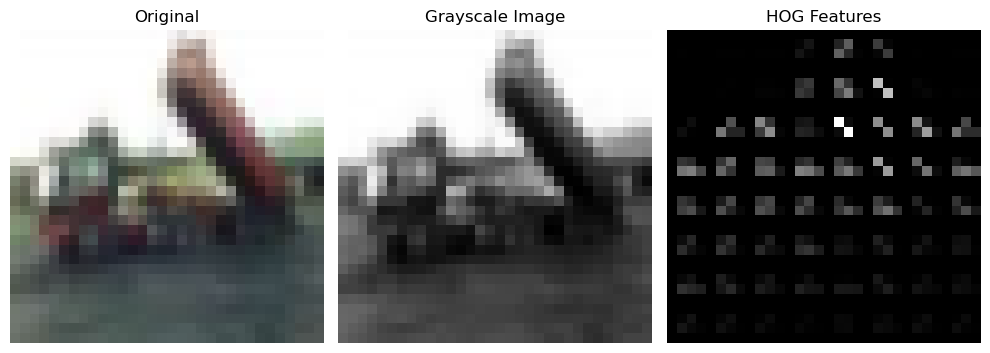

In [74]:
# show sample image
fig, axes = plt.subplots(1, 3, figsize = (10, 5))
axes[0].imshow(sample_image)
axes[0].axis("off")
axes[0].set_title("Original")

sample_grayscale = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
axes[1].imshow(sample_grayscale, cmap = "gray")
axes[1].axis("off")
axes[1].set_title("Grayscale Image")

sample_grayscale_hog = show_hog_image(sample_grayscale)
axes[2].imshow(sample_grayscale_hog, cmap = "gray")
axes[2].axis("off")
axes[2].set_title("HOG Features")

plt.tight_layout()
plt.show()

In [75]:
# sample features
print(cifar_train[0][0].shape)

(1764,)


In [76]:
# define linear model
model = nn.Linear(1764, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [77]:
# initialize data loader
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = BATCH_SIZE, shuffle = False)

In [78]:
# test iterations
counter = 0
for it in range(1):
    for features, labels in train_loader:
        if counter >= 1:
            break
        print("Shape:", features.shape, labels.shape)
        print("First Label:", idx2class[labels[0].item()])

        counter += 1

Shape: torch.Size([128, 1764]) torch.Size([128])
First Label: cat


In [79]:
# train model
losses = []
for it in range(NUM_EPOCHS):
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

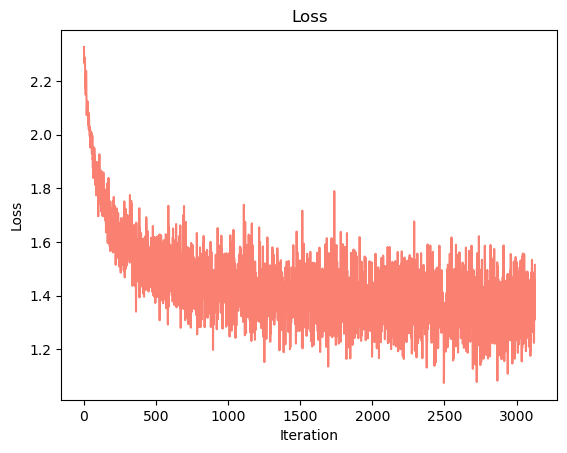

In [80]:
# plot loss
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

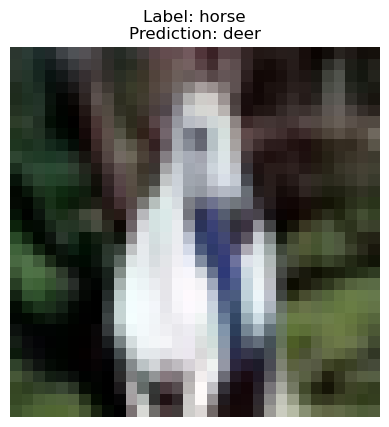

In [81]:
# make sample prediction
idx = random.randint(0, len(cifar_test.data))

sample_image = cifar_test.data[idx, :, :]
sample_target = idx2class[cifar_test.targets[idx]]
prediction = idx2class[np.argmax(model(torch.tensor(cifar_test[idx][0]).to(device)).cpu().detach().numpy())]

# show image
plt.imshow(sample_image)
plt.axis("off")
plt.title("Label: {}\nPrediction: {}".format(sample_target, prediction))
plt.show()

In [82]:
# make predictions on test set
predictions = []
for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    predictions.extend(np.argmax(outputs.cpu().detach().numpy(), axis = 1))

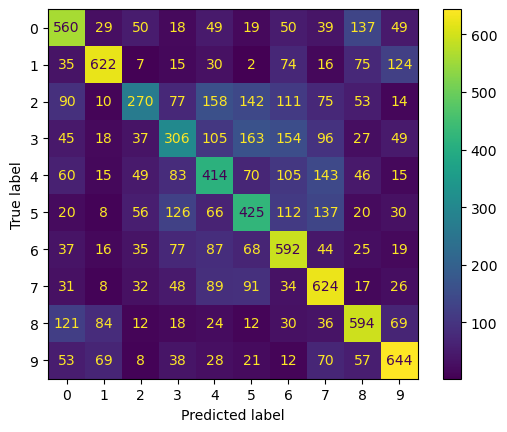

In [83]:
# construct confusion matrix
matrix = metrics.ConfusionMatrixDisplay.from_predictions(cifar_test.targets, predictions)

In [84]:
accuracy = metrics.accuracy_score(cifar_test.targets, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5051


# RGB
Next, we test the model performance without grayscale.

In [85]:
def apply_hog(img, o = 9, ppc = (4, 4), cpb = (2, 2)):
    # apply HOG to a RGB image
    img = np.array(img)
    features = hog(
        img,
        orientations = o,
        pixels_per_cell = ppc,
        cells_per_block = cpb,
        channel_axis = -1 # first dimension
    )

    return torch.tensor(features, dtype = torch.float32)

We only extract HOG features from the image, and convert the output to a `PyTorch` tensor internally.

In [86]:
# reload the dataset with different transformation
transform = transforms.Compose([
    transforms.Lambda(apply_hog),
])

cifar_train = CIFAR10("./data_cifar10/", download = True, transform = transform)
cifar_test = CIFAR10("./data_cifar10/", train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [87]:
print(cifar_train[0][0].shape)

torch.Size([1764])


In [88]:
# define linear model
model = nn.Linear(1764, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [89]:
# initialize data loader
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = BATCH_SIZE, shuffle = False)

In [90]:
# train model
losses = []
for it in range(NUM_EPOCHS):
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

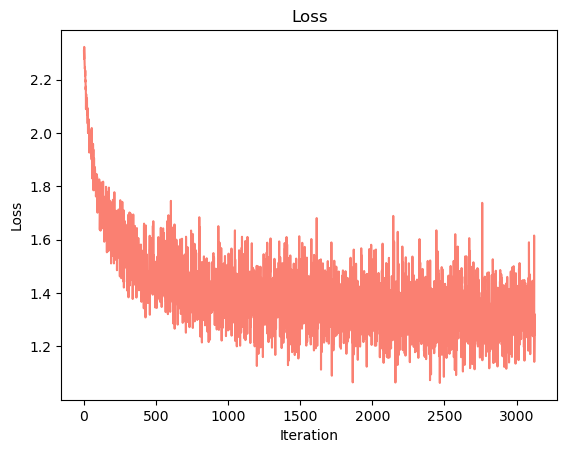

In [91]:
# plot loss
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [92]:
predictions = []
for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    predictions.extend(np.argmax(outputs.cpu().detach().numpy(), axis = 1))

Accuracy: 0.5227


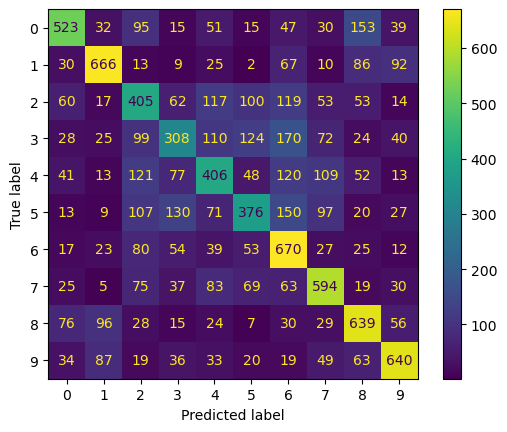

In [93]:
# construct confusion matrix
matrix = metrics.ConfusionMatrixDisplay.from_predictions(cifar_test.targets, predictions)
print("Accuracy:", metrics.accuracy_score(cifar_test.targets, predictions))

# RGB + Concatenation
Here, we test the model performance on a concatenated array of HOG features of each color channel.

In [94]:
def apply_hog_concat(img, o = 9, ppc = (4, 4), cpb = (2, 2)):
    # apply HOG to each color channel
    img = np.array(img)
    features = []
    for i in range(img.shape[-1]):
        features.append(hog(
            img[:, :, i],
            orientations = o,
            pixels_per_cell = ppc,
            cells_per_block = cpb,
        ))

    return torch.tensor(np.concatenate(features), dtype = torch.float32)

In [95]:
# reload the dataset
transform = transforms.Compose([
    transforms.Lambda(apply_hog_concat)
])

cifar_train = CIFAR10("./data_cifar10/", download = True, transform = transform)
cifar_test = CIFAR10("./data_cifar10/", train = False, download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
print(cifar_train[0][0].shape)

torch.Size([5292])


Model input now has a size of $5292$, which is equal to $1764\times3$.

In [97]:
# define linear model
model = nn.Linear(1764 * 3, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [98]:
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size = BATCH_SIZE, shuffle = False)

In [99]:
# train model
losses = []
for it in range(NUM_EPOCHS):
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        optimizer.zero_grad()

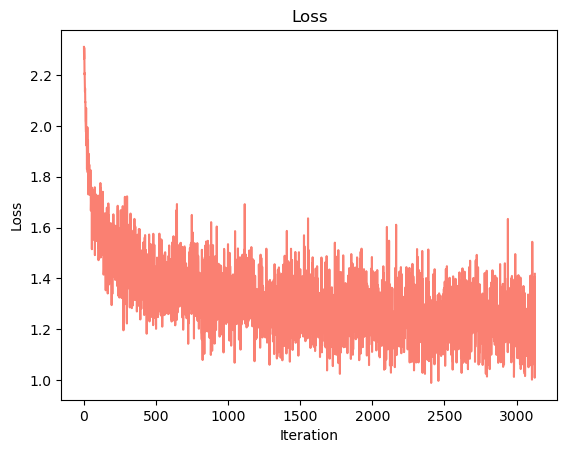

In [100]:
# plot loss
plt.plot(losses, c = "salmon")
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [101]:
# make predictions with test_loader
predictions = []
for features, labels in test_loader:
    features = features.to(device)
    labels = labels.to(device)

    outputs = model(features)
    predictions.extend(np.argmax(outputs.cpu().detach().numpy(), axis = 1))

Accuracy: 0.5179


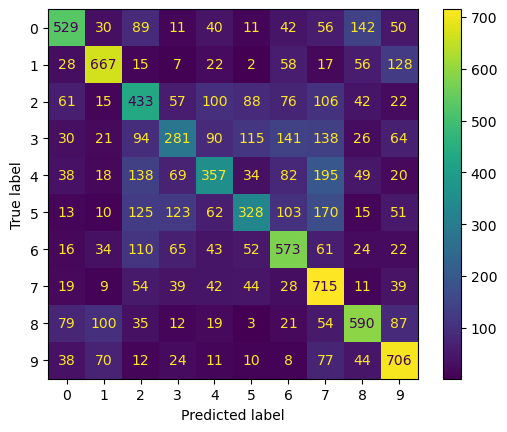

In [102]:
# construct confusion matrix and calculate accuracy
matrix = metrics.ConfusionMatrixDisplay.from_predictions(cifar_test.targets, predictions)
print("Accuracy:", metrics.accuracy_score(cifar_test.targets, predictions))